# Feature Selection

In [1]:
# magic to help out Jupyter notebooks
import os, sys
sys.path.append(os.path.abspath('..\src'))

In [3]:
import pandas as pd 

# allow log messages in notebooks
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# use the pecarn module to bring the PECARN dataset into the notebook
from data import pecarn

# cleaned PECARN data
pecarn_cleaned = pecarn.clean(pecarn.load(fromCsv=False))

# processed data, ready for splitting into training and test sets
X = pecarn_cleaned.drop(columns='PosIntFinal')
y = pecarn.preprocess(pecarn_cleaned[['PosIntFinal']])

INFO:data.pecarn.load:Loading from Pickle file c:\Jan\Capstone\notebooks\PECARN_TBI.pkl


In [5]:
X.head(3)

,AMS,AMSAgitated,AMSOth,AMSRepeat,AMSSleep,AMSSlow,ActNorm,AgeInMonth,Amnesia_verb,Clav,...,SFxPalp,SFxPalpDepress,Sedated,Seiz,SeizLen,SeizOccur,Vomit,VomitLast,VomitNbr,VomitStart
PatNum,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,True,197,0,True,...,0,False,False,False,92,92,False,92,92,92
2,False,False,False,False,False,False,True,64,0,False,...,0,False,False,False,92,92,True,1,3,3
3,True,True,False,False,False,False,False,170,0,True,...,1,True,True,False,92,92,False,92,92,92


# Setup

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y, random_state=1234)

# create a placeholder
feature_stats = pd.DataFrame(index=X.columns)

# Variance

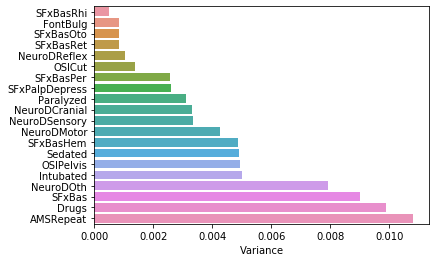

In [7]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
selector.fit(X)
feature_stats['Variance'] = selector.variances_

import seaborn as sns
variance = feature_stats.sort_values(by='Variance')[:20]
sns.barplot(data=variance, y=variance.index, x='Variance')

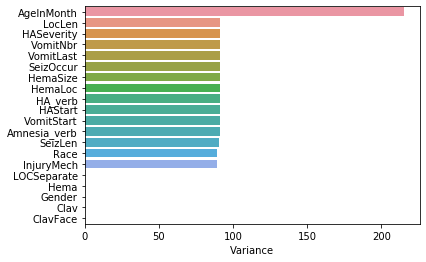

In [8]:
variance = feature_stats.sort_values(by='Variance', ascending=False)[:20]
sns.barplot(data=variance, y=variance.index, x='Variance')

# Pearson's Chi Square Test

In [9]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X, y)
feature_stats['Chi2'] = chi2_selector.scores_

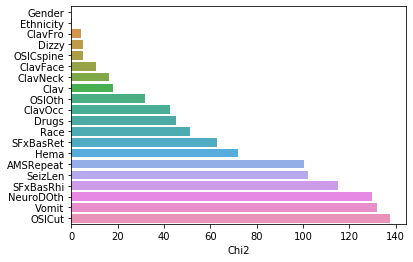

In [10]:
import seaborn as sns
chi_2 = feature_stats.sort_values(by='Chi2')[:20]
sns.barplot(data=chi_2, y=chi_2.index, x='Chi2')

# Mutual Information Statistic

In [11]:
def mutual_info_classif_custom(X, y):
    return mutual_info_classif(X, y, True)


mis_selector = SelectKBest(score_func=mutual_info_classif_custom, k='all')
mis_selector.fit(X, y)
feature_stats['Mutual Info'] = mis_selector.scores_

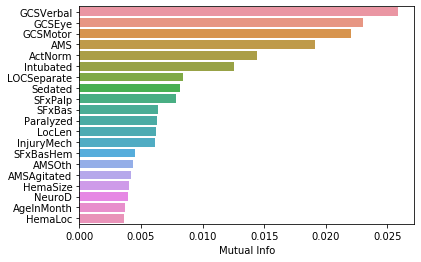

In [12]:
import seaborn as sns
mis = feature_stats.sort_values(by='Mutual Info', ascending=False)[:20]
sns.barplot(data=mis, y=mis.index, x='Mutual Info')

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, accuracy_score

# note, not using ExtraTreesClassifier as you cannot specify scoring metric, and the default (accuracy) is not a good choice
#clf = ExtraTreesClassifier(n_estimators=10)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# select features from model
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

print(f"F1 is {f1_score(y_test, y_pred)}")
print(f"Accuracy is {accuracy_score(y_test, y_pred)}")

F1 is 0.36455696202531646
Accuracy is 0.9768535595721136


In [14]:
selected_features = X[X.columns[model.get_support()]]
selected_features.columns

Index(['ActNorm', 'AgeInMonth', 'Amnesia_verb', 'GCSVerbal', 'Gender',
       'HA_verb', 'HemaLoc', 'HemaSize', 'InjuryMech', 'Intubated',
       'LOCSeparate', 'LocLen', 'OSI', 'Race', 'SFxPalp', 'VomitNbr'],
      dtype='object')

In [15]:
import seaborn as sns

feat_importance = pd.DataFrame(clf.feature_importances_, index=features.drop(columns='PosIntFinal').columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

sns.barplot(data=feat_importance[:20], y=feat_importance[:20].index, x='Importance')

NameError: name 'features' is not defined

# Use TPOT to optimize features
This uses TPOT and an ExtraTreesClassifier as a baseline model and tests feature selection algorithms.

In [17]:
# https://github.com/EpistasisLab/tpot/blob/master/tpot/config/classifier_light.py
# https://github.com/EpistasisLab/tpot/blob/master/tpot/config/classifier.py

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

# specify the pipelines that TPOT will optmize - selected from the two default classifiers
tpot_config = {

    # Classifiers
    'sklearn.tree.DecisionTreeClassifier': {
        'criterion': ["gini"], #, "entropy"],
        #'max_depth': range(1, 11),
        'min_samples_split': 2,
        'min_samples_leaf': 1
    },

    # 'sklearn.neighbors.KNeighborsClassifier': {
    #     'n_neighbors': range(1, 101),
    #     'weights': ["uniform", "distance"],
    #     'p': [1, 2]
    # },

    # Preprocesssors
    # 'sklearn.cluster.FeatureAgglomeration': {
    #     'linkage': ['ward', 'complete', 'average'],
    #     'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
    # },

    # 'sklearn.decomposition.PCA': {
    #     'svd_solver': ['randomized'],
    #     'iterated_power': range(1, 11)
    # },

    # 'sklearn.kernel_approximation.RBFSampler': {
    #     'gamma': np.arange(0.0, 1.01, 0.05)
    # },

    # 'xgboost.XGBClassifier': {
    #     'n_estimators': [50],
    #     'max_depth': range(1, 11),
    #     'learning_rate': [1e-2, 1e-1, 0.5],
    #     'subsample': np.arange(0.05, 1.01, 0.05),
    #     'min_child_weight': range(1, 21),
    #     'nthread': [1]
    # },

    # 'tpot.builtins.OneHotEncoder': {
    #     'minimum_fraction': [0.05, 0.1, 0.15, 0.2, 0.25],
    #     'sparse': [False],
    #     'threshold': [10]
    # },


    # # Selectors
    # 'sklearn.feature_selection.SelectFwe': {
    #     'alpha': np.arange(0, 0.05, 0.001),
    #     'score_func': {
    #         'sklearn.feature_selection.f_classif': None
    #     }
    # },

    # 'sklearn.feature_selection.VarianceThreshold': {
    #     'threshold': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
    # }

    # 'sklearn.feature_selection.SelectFromModel': {
    #     'threshold': np.arange(0, 1.01, 0.05),
    #     'estimator': {
    #         'sklearn.tree.DecisionTreeClassifier': {
    #             'criterion': ["gini", "entropy"],
    #             # 'max_depth': range(1, 11),
    #             # 'min_samples_split': range(2, 21),
    #             # 'min_samples_leaf': range(1, 21)
    #         }
    #     }
    # }

}

In [18]:
from tpot import TPOTClassifier

# create TPOT optimizer
clf_opt = TPOTClassifier(config_dict=tpot_config,
                        scoring='f1',
                        generations=2,
                        population_size=10, 
                        #memory='auto',
                        n_jobs=-1,
                        early_stop=3,
                        verbosity=2)

ModuleNotFoundError: No module named 'tpot'

In [19]:
X_train.shape

NameError: name 'X_train' is not defined

In [20]:
y_train.shape

NameError: name 'y_train' is not defined

In [21]:
clf_opt.fit(X_train, y_train)

NameError: name 'clf_opt' is not defined

In [22]:
clf_opt.fitted_pipeline_

NameError: name 'clf_opt' is not defined

In [23]:
clf_opt.score(X_test, y_test)

NameError: name 'clf_opt' is not defined

In [24]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(clf, X_test, y_test)

NameError: name 'X_test' is not defined